# Fetch dataset

In [1]:
!pip install -q kaggle
!kaggle datasets download 'sumanthvrao/daily-climate-time-series-data'
!mkdir 'daily-climate-time-series-data'
!unzip -o 'daily-climate-time-series-data.zip' -d 'daily-climate-time-series-data'

Dataset URL: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data
License(s): CC0-1.0
daily-climate-time-series-data.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘daily-climate-time-series-data’: File exists
Archive:  daily-climate-time-series-data.zip
  inflating: daily-climate-time-series-data/DailyDelhiClimateTest.csv  
  inflating: daily-climate-time-series-data/DailyDelhiClimateTrain.csv  


In [2]:
import os
import pandas as pd
import numpy as np

dir = 'daily-climate-time-series-data'
df = pd.read_csv(os.path.join(dir, 'DailyDelhiClimateTrain.csv'))

In [3]:
X_df = df.loc[np.arange(0,len(df)-1), ['meantemp', 'humidity', 'wind_speed', 'meanpressure']]
y_df = df.loc[np.arange(1,len(df)), ['meantemp']].reset_index().drop('index', axis=1)
X, y = X_df.to_numpy(), y_df.to_numpy()
assert X.shape[0] == y.shape[0]
assert (X[1:,0:1] == y[0:-1]).all()

# Create model
Modifying the example from https://medium.com/iet-vit/lets-build-a-rnn-pytorch-style-c960207f1fb3 to create the model and training loop.

In [4]:
import torch

class RNN(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, device='cpu'):
        super(RNN, self).__init__()

        self.hidden_dim=hidden_dim
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = torch.nn.RNN(input_size, hidden_dim, n_layers, batch_first=True, device=device)   # I don't trust this implementation...
        # last, fully-connected layer
        self.fc = torch.nn.Linear(hidden_dim, output_size, device=device)

        self.device = device

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)

        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)

        # get final output
        output = self.fc(r_out)

        return output, hidden

def net_eq(net1, net2):
  for p1, p2 in zip(list(net1.parameters()), list(net2.parameters())):
    if not (p1 == p2).all():
      return False
  return True

assert not net_eq(
    RNN(input_size=4, output_size=1, hidden_dim=4, n_layers=1),
    RNN(input_size=4, output_size=1, hidden_dim=4, n_layers=1)
)
assert net_eq(
    n_test:=RNN(input_size=4, output_size=1, hidden_dim=4, n_layers=1),
    n_test
)
assert len(list(RNN(4, 1, 32, 27).parameters())) == (27*4+2)

In [5]:
from tqdm.notebook import tqdm

def train_hook(rnn, X, y, batch_timesteps, n_batches, n_epochs):  # Again following this example a bit: https://medium.com/iet-vit/lets-build-a-rnn-pytorch-style-c960207f1fb3
  criterion = torch.nn.MSELoss()
  for epoch in tqdm(range(n_epochs), total=n_epochs, desc='Epochs', leave=False):
    hidden = None
    for step in tqdm(range(n_batches), total=n_batches, desc='Batches', leave=False):
      if (step*batch_timesteps) > len(y):
        break
      X_batch = X[(step*batch_timesteps):((step+1)*batch_timesteps), :]
      y_batch = y[(step*batch_timesteps):((step+1)*batch_timesteps)]

      X_batch, y_batch = torch.Tensor(X_batch).unsqueeze(0), torch.Tensor(y_batch)
      X_batch = X_batch.to(rnn.device)
      y_batch = y_batch.to(rnn.device)

      prediction, hidden = rnn(X_batch, hidden)
      hidden = hidden.data

      loss = criterion(prediction, y_batch)
      loss.backward()
  return rnn, loss


def train_normal(rnn, X, y, batch_timesteps, n_batches, n_epochs, optimizer):  # Again following this example a bit: https://medium.com/iet-vit/lets-build-a-rnn-pytorch-style-c960207f1fb3
  criterion = torch.nn.MSELoss()
  for epoch in tqdm(range(n_epochs), total=n_epochs, desc='Epochs', leave=False):
    hidden = None
    for step in tqdm(range(n_batches), total=n_batches, desc='Batches', leave=False):
      if (step*batch_timesteps) > len(y):
        break
      X_batch = X[(step*batch_timesteps):((step+1)*batch_timesteps), :]
      y_batch = y[(step*batch_timesteps):((step+1)*batch_timesteps)]

      X_batch, y_batch = torch.Tensor(X_batch).unsqueeze(0), torch.Tensor(y_batch)
      X_batch = X_batch.to(rnn.device)
      y_batch = y_batch.to(rnn.device)

      prediction, hidden = rnn(X_batch, hidden)
      hidden = hidden.data

      loss = criterion(prediction, y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  return rnn, loss

# Train an RNN with proper MEBP vs ordinary BPTT
Using (and modifying) the implementation of MEBP from https://pytorch.org/tutorials/intermediate/optimizer_step_in_backward_tutorial.html

In [6]:
from copy import deepcopy
model_1 = RNN(input_size=4, output_size=1, hidden_dim=32, n_layers=32).cpu()
model_2 = deepcopy(model_1).cpu()
assert net_eq(model_1, model_2)

optimizer_dict = {p: torch.optim.Adam([p], foreach=False) for p in model_1.parameters()}

def optimizer_post_acc_grad_hook(parameter) -> None:
  optimizer_dict[parameter].step()
  optimizer_dict[parameter].zero_grad()

for p in model_1.parameters():
   p.register_post_accumulate_grad_hook(optimizer_post_acc_grad_hook)

# Check equality
model_1, loss_1 = train_hook(model_1, X, y, batch_timesteps=10, n_batches=2, n_epochs=2)
model_2, loss_2 = train_normal(model_2, X, y, batch_timesteps=10, n_batches=2, n_epochs=2, optimizer = torch.optim.Adam(model_2.parameters(), foreach=False))
assert net_eq(model_1, model_2)
assert loss_1 == loss_2

# Sanity check:
model_1, _ = train_hook(model_1, X, y, batch_timesteps=10, n_batches=1, n_epochs=1)
assert not net_eq(model_1, model_2)

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

# RNN memory profiling
For a detailed view, download the `.pickle` files and drag them into [PyTorch memory visualizer](https://pytorch.org/memory_viz)

In [7]:
(1024*5+1024*1025*255*2+1025)*4 / 1024 / 1024  # GB of model parameters in float32

2042.0156288146973

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

18700

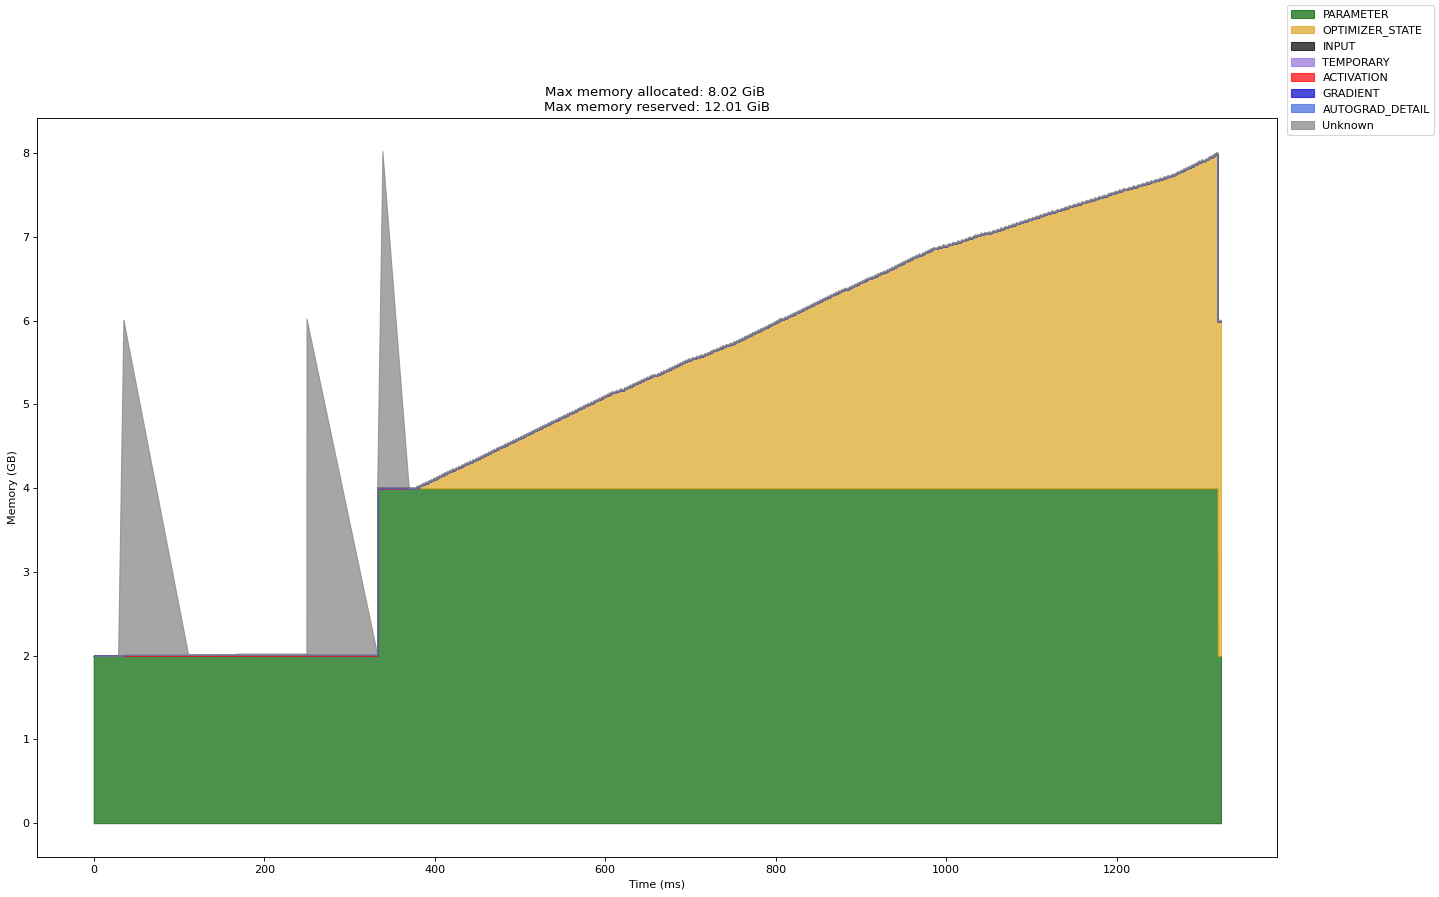

In [8]:
model_1 = RNN(input_size=4, output_size=1, hidden_dim=1024, n_layers=256, device='cuda:0')

# Using the approach from: https://pytorch.org/tutorials/intermediate/optimizer_step_in_backward_tutorial.html
optimizer_dict = {p: torch.optim.Adam([p], foreach=False) for p in model_1.parameters()}

# Define our hook, which will call the optimizer ``step()`` and ``zero_grad()``
def optimizer_post_acc_grad_hook(parameter) -> None:
  optimizer_dict[parameter].step()
  optimizer_dict[parameter].zero_grad()

# Register the hook onto every parameter
for p in model_1.parameters():
   p.register_post_accumulate_grad_hook(optimizer_post_acc_grad_hook)

torch.cuda.memory._record_memory_history()
p = torch.profiler.profile(
  activities=[
    torch.profiler.ProfilerActivity.CPU,
    torch.profiler.ProfilerActivity.CUDA,
  ],
  record_shapes=True,
  with_stack=True,
  profile_memory=True,
)
p.start()
model_1, loss_1 = train_hook(model_1, X, y, batch_timesteps=5, n_batches=1, n_epochs=1)
p.step()
p.stop()
p.export_memory_timeline("trace_model_1.html")
torch.cuda.memory._dump_snapshot("trace_model_1.pickle")

import gc
model_1.rnn.cpu()
model_1.cpu()
del model_1.rnn
del model_1
torch.cuda.empty_cache()
gc.collect()

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

172609

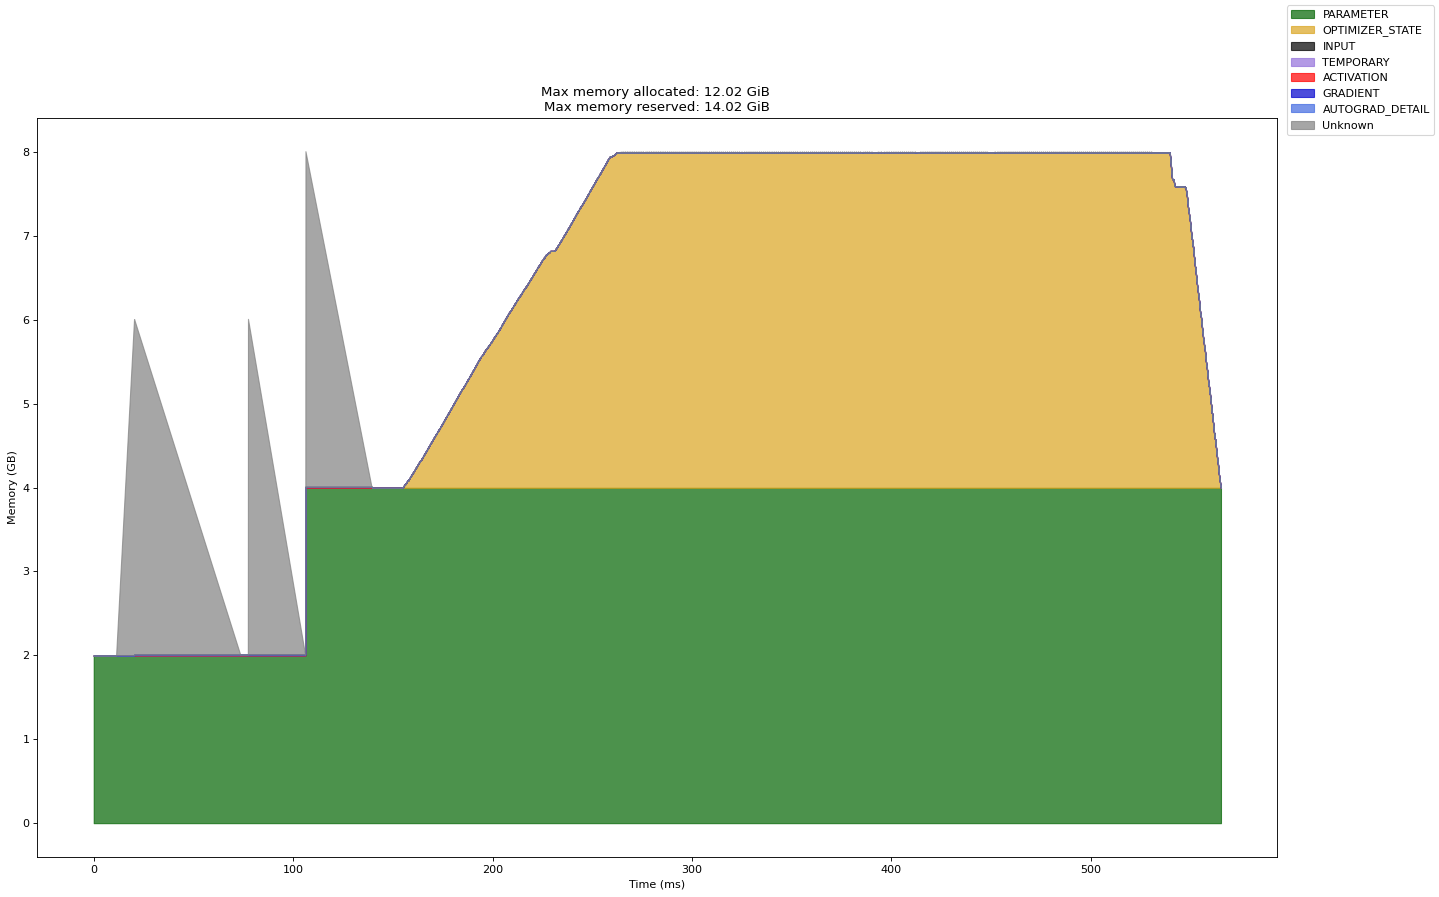

In [9]:
torch.cuda.memory._record_memory_history()
model_2 = RNN(input_size=4, output_size=1, hidden_dim=1024, n_layers=256, device='cuda:0')
p = torch.profiler.profile(
  activities=[
    torch.profiler.ProfilerActivity.CPU,
    torch.profiler.ProfilerActivity.CUDA,
  ],
  record_shapes=True,
  with_stack=True,
  profile_memory=True,
)
p.start()
model_2, loss_2 = train_normal(model_2, X, y, batch_timesteps=5, n_batches=1, n_epochs=1, optimizer = torch.optim.Adam(model_2.parameters(), foreach=False))
p.step()
p.stop()
p.export_memory_timeline("trace_model_2.html")
torch.cuda.memory._dump_snapshot("trace_model_2.pickle")

import gc
model_2.rnn.cpu()
model_2.cpu()
del model_2.rnn
del model_2
torch.cuda.empty_cache()
gc.collect()